In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error
from tensorflow.keras.layers import Reshape
import matplotlib.pyplot as plt

In [2]:
# Import Dataset
df = pd.read_csv('F:/Works/Application of ML/Dataset/AQI_Time_Series_Dataset.csv', low_memory=False)
df.head()

,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,pm10,...,wind_direc,datacreationdate,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,基隆,基隆市,30.0,NaN,良好,1.1,0.22,37,35.0,14.0,...,NaN,25-11-16 13:00,NaN,0.28,3.0,9.0,NaN,NaN,NaN,NaN
1,麥寮,雲林縣,49.0,NaN,良好,3.8,0.31,56,30.0,82.0,...,NaN,25-11-16 13:00,NaN,0.36,14.0,53.0,NaN,NaN,NaN,NaN
2,關山,臺東縣,26.0,NaN,良好,1.2,NaN,NaN,19.0,19.0,...,NaN,25-11-16 13:00,NaN,NaN,8.0,17.0,NaN,NaN,NaN,NaN
3,馬公,澎湖縣,36.0,NaN,良好,1.1,0.19,40,35.0,28.0,...,NaN,25-11-16 13:00,NaN,0.18,11.0,22.0,NaN,NaN,NaN,NaN
4,金門,金門縣,42.0,NaN,良好,3.3,0.37,28,21.0,36.0,...,NaN,25-11-16 13:00,NaN,0.36,13.0,34.0,NaN,NaN,NaN,NaN


In [3]:
# Drop columns 'B' and 'C'
df.drop(columns=['sitename','county', 'aqi', 'pollutant', 'status', 'o3_8hr', 'wind_speed', 'wind_direc', 'nox', 'no',
                'unit', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'longitude', 'latitude', 'siteid'], inplace=True)
df.head()

,so2,co,o3,pm10,pm2.5,no2,datacreationdate
0,1.1,0.22,37,14.0,4,3.0,25-11-16 13:00
1,3.8,0.31,56,82.0,17,9.5,25-11-16 13:00
2,1.2,NaN,NaN,19.0,8,4.2,25-11-16 13:00
3,1.1,0.19,40,28.0,17,1.9,25-11-16 13:00
4,3.3,0.37,28,36.0,14,10.0,25-11-16 13:00


In [4]:
# Check for null values in each column
df.isnull().sum()

so2                 137550
co                  112535
o3                  123687
pm10                139802
pm2.5               130015
no2                 165415
datacreationdate         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5805726 entries, 0 to 5805725
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   so2               object
 1   co                object
 2   o3                object
 3   pm10              object
 4   pm2.5             object
 5   no2               object
 6   datacreationdate  object
dtypes: object(7)
memory usage: 310.1+ MB


In [6]:
# Convert first six columns to numeric
df[['so2', 'co', 'o3', 'pm10', 'pm2.5', 'no2']] = df[['so2', 'co', 'o3', 'pm10', 'pm2.5', 'no2']].apply(pd.to_numeric, errors='coerce')
# Convert 'datacreationdate' column to datetime
df['datacreationdate'] = pd.to_datetime(df['datacreationdate'], format='%d-%m-%y %H:%M', errors='coerce')
df.head()

,so2,co,o3,pm10,pm2.5,no2,datacreationdate
0,1.1,0.22,37.0,14.0,4.0,3.0,2016-11-25 13:00:00
1,3.8,0.31,56.0,82.0,17.0,9.5,2016-11-25 13:00:00
2,1.2,NaN,NaN,19.0,8.0,4.2,2016-11-25 13:00:00
3,1.1,0.19,40.0,28.0,17.0,1.9,2016-11-25 13:00:00
4,3.3,0.37,28.0,36.0,14.0,10.0,2016-11-25 13:00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5805726 entries, 0 to 5805725
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   so2               float64       
 1   co                float64       
 2   o3                float64       
 3   pm10              float64       
 4   pm2.5             float64       
 5   no2               float64       
 6   datacreationdate  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 310.1 MB


In [8]:
# Check if any date is repeating in the DataFrame column
is_date_repeating = df['datacreationdate'].duplicated().any()

# Print the result
if is_date_repeating:
    print("Yes, some dates are repeating.")
else:
    print("No, all dates are unique.")

Yes, some dates are repeating.


In [9]:
# Remove rows with repeated dates
df_unique_dates = df.drop_duplicates(subset=['datacreationdate'])

# Print the DataFrame after removing repeated dates
df_unique_dates.head()

,so2,co,o3,pm10,pm2.5,no2,datacreationdate
0,1.1,0.22,37.0,14.0,4.0,3.0,2016-11-25 13:00:00
76,3.9,0.46,92.0,112.0,66.0,19.0,2016-11-25 14:00:00
152,NaN,NaN,30.0,18.0,6.0,NaN,2016-11-25 15:00:00
228,1.1,0.25,39.0,19.0,6.0,3.6,2016-11-25 16:00:00
304,6.8,0.29,53.0,61.0,NaN,NaN,2016-11-25 17:00:00


In [10]:
# Check if any date is repeating in the DataFrame column
is_date_repeating = df_unique_dates['datacreationdate'].duplicated().any()

# Print the result
if is_date_repeating:
    print("Yes, some dates are repeating.")
else:
    print("No, all dates are unique.")

No, all dates are unique.


In [11]:
# Convert 'datacreationdate' column to only date
df['datacreationdate'] = pd.to_datetime(df['datacreationdate']).dt.date

# Group by 'datacreationdate' and calculate the mean for other columns
df_mean = df.groupby('datacreationdate').mean().reset_index()

df_mean.head()

,datacreationdate,so2,co,o3,pm10,pm2.5,no2
0,2016-11-25,2.818773,0.430841,36.267782,41.316808,16.665354,16.060654
1,2016-11-26,2.423315,0.430870,27.113356,39.965232,17.288915,14.354335
2,2016-11-27,1.855501,0.410151,20.977514,21.127849,9.280876,13.340066
3,2016-11-28,2.739353,0.403904,33.445877,53.866619,22.639594,12.817808
4,2016-11-29,3.123391,0.488798,32.663070,59.886589,24.576782,17.698004


In [12]:
# Rename the column 'datacreationdate' to 'Date'
df_mean = df_mean.rename(columns={'datacreationdate': 'Date'})
df_mean.head()

,Date,so2,co,o3,pm10,pm2.5,no2
0,2016-11-25,2.818773,0.430841,36.267782,41.316808,16.665354,16.060654
1,2016-11-26,2.423315,0.430870,27.113356,39.965232,17.288915,14.354335
2,2016-11-27,1.855501,0.410151,20.977514,21.127849,9.280876,13.340066
3,2016-11-28,2.739353,0.403904,33.445877,53.866619,22.639594,12.817808
4,2016-11-29,3.123391,0.488798,32.663070,59.886589,24.576782,17.698004


In [13]:
# Rename columns
df_mean = df_mean.rename(columns={'datacreationdate': 'Date', 'so2': 'SO2', 'co': 'CO', 'o3': 'O3', 'pm10': 'PM10', 'pm2.5': 'PM2.5', 'no2': 'NO2'})

# Reorder columns
df_mean = df_mean.reindex(columns=['Date','PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3'])
df_mean.head()

,Date,PM2.5,PM10,SO2,NO2,CO,O3
0,2016-11-25,16.665354,41.316808,2.818773,16.060654,0.430841,36.267782
1,2016-11-26,17.288915,39.965232,2.423315,14.354335,0.430870,27.113356
2,2016-11-27,9.280876,21.127849,1.855501,13.340066,0.410151,20.977514
3,2016-11-28,22.639594,53.866619,2.739353,12.817808,0.403904,33.445877
4,2016-11-29,24.576782,59.886589,3.123391,17.698004,0.488798,32.663070


In [14]:
datetime_column = 'Date'
feature_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

In [15]:
data = df_mean[feature_columns].values

In [16]:
# Preprocess the data
scaler_LSTM = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_LSTM.fit_transform(data)

# Save the scaler for LSTM
dump(scaler_LSTM, 'F:/Works/Application of ML/Final/scaler_LSTM.joblib')

['F:/Works/Application of ML/Final/scaler_LSTM.joblib']

In [17]:
# Function to create time series dataset
def create_dataset(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [18]:
# Define the window size
window_size = 365  # Number of past time steps to consider

# Create the time series dataset
X, y = create_dataset(scaled_data, window_size)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [20]:
# Define the learning rate
learning_rate = 0.0001 

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define the model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1)) 
model.add(Dense(X_train.shape[2]))  # Output layer predicts the next value for each feature

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), shuffle=True)

F:\Works\Application of ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 0.1828 - val_loss: 0.0968
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.1032 - val_loss: 0.0270
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0321 - val_loss: 0.0195
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0239 - val_loss: 0.0185
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 0.0238 - val_loss: 0.0176
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0208 - val_loss: 0.0169
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0209 - val_loss: 0.0162
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0202 - val_loss: 0.0154
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 0.0196 - val_loss: 0.0144
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - loss: 0.0190 - val_loss: 0.0136
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0178 - val_loss: 0.0130
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,700 (217.58 KB)

 Trainable params: 18,566 (72.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,134 (145.06 KB)

In [22]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0085
Test Loss: 0.008033162914216518


In [23]:
# Calculate RMSE
test_rmse = np.sqrt(test_loss)
print(f'Test RMSE: {test_rmse}')

Test RMSE: 0.08962791370001044


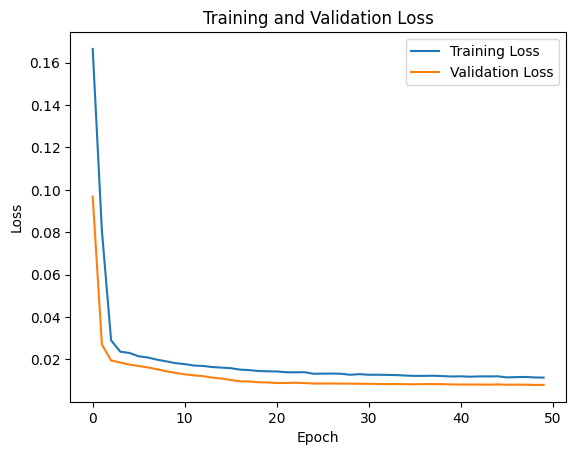

In [24]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an image
plt.savefig('F:/Works/Application of ML/Final/LSTM_training_validation_loss.png')

In [25]:
# Predict values using the trained model
y_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


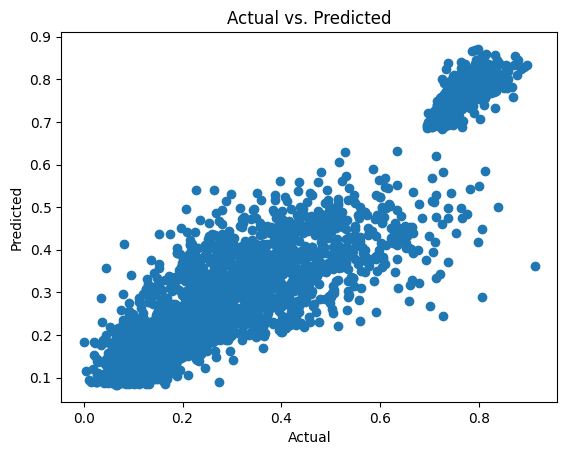

In [26]:
# Plot predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [27]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

MAE: 0.06388718627028288
MAPE: 32.35049292003532
RMSE: 0.08962792045869888


In [29]:
# Save the model to a file
model.save('F:/Works/Application of ML/Final/LSTM_trained_model.h5')

In [30]:
# Cleaned Dataset
LSTM_cleaned_data = pd.DataFrame(data, columns=feature_columns)
LSTM_cleaned_data.head()

,PM2.5,PM10,SO2,NO2,CO,O3
0,16.665354,41.316808,2.818773,16.060654,0.430841,36.267782
1,17.288915,39.965232,2.423315,14.354335,0.430870,27.113356
2,9.280876,21.127849,1.855501,13.340066,0.410151,20.977514
3,22.639594,53.866619,2.739353,12.817808,0.403904,33.445877
4,24.576782,59.886589,3.123391,17.698004,0.488798,32.663070


In [31]:
# Export the DataFrame to a CSV file
LSTM_cleaned_data.to_csv('F:/Works/Application of ML/Final/LSTM_cleaned_data.csv', index=False)